## Import library

In [101]:
import os
import glob
import natsort
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, accuracy_score
import copy
import datetime
import json
from ast import literal_eval
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

## Define functions

In [25]:
def get_Data_activity(dataPath, date, data_collection):

    tmp_datetime = datetime.datetime.strptime(date, '%Y-%m-%d')

    date_list = [tmp_datetime + datetime.timedelta(minutes=tmp) for tmp in range(1440)]
    value_list = [0] * 1440
    if 'time' not in data_collection:
        data_collection['time'] = np.array([])
        data_collection['value'] = np.array([])
    data_collection['time'] = np.append(data_collection['time'], np.array(date_list))
    data_collection['value'] = np.append(data_collection['value'], np.array(value_list))

    with open(dataPath) as f:
        s = f.read()

    if s != '':
        tmp_s = s.replace("'", '"')
        tmpData = json.loads(tmp_s)

        kindOfData = 'activities-heart-intraday'  
        if kindOfData in tmpData:
            for oneMinute_data in tmpData[kindOfData]['dataset']:
                tmp = datetime.datetime.strptime(date + ' ' + oneMinute_data['time'], '%Y-%m-%d %H:%M:%S')
                data_collection['value'][data_collection['time'] == tmp] = oneMinute_data['value']

    return data_collection

def get_Data_sleep(dataPath, data_collection):

    with open(dataPath) as f:
        s = f.read()

    tmp_s = s.replace("'", '"')
    tmp_s = tmp_s.replace('True', '"True"')
    tmp_s = tmp_s.replace('False', '"False"')
    tmpData = json.loads(tmp_s)

    if tmpData['sleep'] != []:
        for ii in range(len(tmpData['sleep'])):
            for sleep_data in tmpData['sleep'][ii]['levels']['data']:
                duration_minutes = sleep_data['seconds'] // 60
                start_datetime = datetime.datetime.strptime(sleep_data['dateTime'].split('.000')[0], '%Y-%m-%dT%H:%M:%S')

                for minute in range(duration_minutes):
                    tmp_datetime = start_datetime + datetime.timedelta(minutes=minute)
                    hour_min = datetime.datetime(tmp_datetime.year, tmp_datetime.month, tmp_datetime.day, tmp_datetime.hour, tmp_datetime.minute)

                    data_collection['sleep'][data_collection['time'] == hour_min] = int(1)

    return data_collection


def get_sleep_hr(data_collection, sleep=True, all=False):
    time = data_collection['time']
    hr_value = data_collection['value']
    sleep_flg = data_collection['sleep']
    
    df = pd.DataFrame(np.array([time, hr_value, sleep_flg]).T, columns=["time", "hr_value", "sleep_flg"])
    
    if not all:
        if sleep:
            df = df[df["sleep_flg"]==1]
        else:
            df = df[df["sleep_flg"]==0]
    
    return df

def get_sleep_hr_data(hr_data_paths, sleep_data_paths):

    data_collection = dict()
    for hr_data_path in hr_data_paths:
        date = os.path.basename(hr_data_path).split('.txt')[0]
        data_collection = get_Data_activity(hr_data_path, date, data_collection)
    
    start_datetime = datetime.datetime.strptime(os.path.basename(sleep_data_paths[0]).split('.txt')[0], '%Y-%m-%d')
    end_datetime = datetime.datetime.strptime(os.path.basename(sleep_data_paths[-1]).split('.txt')[0], '%Y-%m-%d') + datetime.timedelta(days=1)
    data_collection['sleep'] = np.array([0] * 1440 * (end_datetime - start_datetime).days)

    sleep_start_end_datetime = dict()
    for sleep_data_path in sleep_data_paths:
        try:
            data_collection = get_Data_sleep(sleep_data_path, data_collection)
            date = datetime.datetime.strptime(os.path.basename(sleep_data_path).split('.txt')[0], '%Y-%m-%d')
            with open(sleep_data_path) as file:
                data_text = file.read()
            tmp_s = data_text.replace("'", '"')
            tmp_s = tmp_s.replace('true', '"True"')
            tmp_s = tmp_s.replace('false', '"False"')
            data_dict = json.loads(tmp_s)
            start_time = data_dict['sleep'][0]['startTime'].split('.')[0]
            end_time = data_dict['sleep'][0]['endTime'].split('.')[0]
            start_datetime = datetime.datetime.strptime(start_time, '%Y-%m-%dT%H:%M:%S')
            end_datetime = datetime.datetime.strptime(end_time, '%Y-%m-%dT%H:%M:%S')

            sleep_start_end_datetime[date] = {'start':start_datetime, 'end':end_datetime}
        except:
            pass
    df = pd.DataFrame()
    df['time'] = data_collection['time']
    df['hr_value'] = data_collection['value']
    df['sleep_flg'] = data_collection['sleep']

    return df, sleep_start_end_datetime

def get_RHR(hr_data_paths):
    date_list = []
    rhr_list = []

    for hr_data_path in hr_data_paths:
        #Get date
        date = datetime.datetime.strptime(os.path.basename(hr_data_path).split('.txt')[0], '%Y-%m-%d')
        #Get RHR value
        with open(hr_data_path) as file:
            hr_data_text = file.read()
        try:
            hr_data_dict = literal_eval(hr_data_text)
            rhr_value = hr_data_dict['activities-heart'][0]['value']['restingHeartRate']
            rhr_list.append(rhr_value)
            date_list.append(date)
        except:
            pass
    #Create RHR data frame and output the data frame as csv
    df_rhr = pd.DataFrame()
    df_rhr['Date'] = date_list
    df_rhr['Date'] = pd.to_datetime(df_rhr['Date'])
    df_rhr['RHR'] = rhr_list

    return df_rhr

#=========================
# Get minimum heart rate during sleep per day
#=========================
def get_hr_min_per_day(sleep_data_paths, df_all_sleep_data):
    #Get all sleep data
    sleep_data = dict()
    for sleep_data_path in sleep_data_paths:
        date = os.path.basename(sleep_data_path).split('.txt')[0]
        with open(sleep_data_path) as file:
            data_text = file.read() 
        data_dict = literal_eval(data_text)
        sleep_data[date] = data_dict

    #Get start and end times of sleep per day
    start_and_end_daitetime = dict()

    for date, data in sleep_data.items():
        try:
            start_date = data['sleep'][0]['startTime'].split('T')[0]
            end_date = data['sleep'][0]['endTime'].split('T')[0]
            start_time = data['sleep'][0]['startTime'].split('T')[1].split('.')[0]
            end_time = data['sleep'][0]['endTime'].split('T')[1].split('.')[0]
            start_datetime = datetime.datetime.strptime(start_date + ' ' + start_time, '%Y-%m-%d %H:%M:%S')
            end_datetime = datetime.datetime.strptime(end_date + ' ' + end_time, '%Y-%m-%d %H:%M:%S')

            datetime_dict = dict()
            datetime_dict['start'] = start_datetime
            datetime_dict['end'] = end_datetime

            start_and_end_daitetime[date] = datetime_dict
        except IndexError as e:
            print(f'Sleep data of {date} is missing.')
    
    #Get minimum heart rate during sleep per day
    min_dict = dict()
    
    for date, time in start_and_end_daitetime.items():
        start = time['start']
        end = time['end']
        sleep_hr_value = np.array(df_all_sleep_data.loc[start:end]['hr_value'])
        sleep_hr_value_min = sleep_hr_value.min()
        min_dict[date] = sleep_hr_value_min
    
    return min_dict

## データセット構築・解析のための準備

In [18]:
# 使用するデータのパスなどの設定
file_path = 'analysis_data'
fitbit_path = glob.glob(os.path.join(file_path, 'activities', '*'))
hr_path = os.path.join(fitbit_path[0], 'hr')
sleep_path = os.path.join(fitbit_path[0], 'sleep')

# データファイルのパスを取得
hr_data_paths = natsort.natsorted(glob.glob(os.path.join(hr_path, '*.txt')))
sleep_data_paths = natsort.natsorted(glob.glob(os.path.join(sleep_path, '*.txt')))

### Load RHR

In [30]:
df_analysis_data = get_RHR(hr_data_paths=hr_data_paths)
df_analysis_data = df_analysis_data.set_index('Date')
df_analysis_data.head()

,RHR
Date,
2022-06-05,65
2022-06-06,67
2022-06-07,69
2022-06-08,66
2022-06-09,65


### Load HR during sleep

In [29]:
df_hr, sleep_time = get_sleep_hr_data(hr_data_paths, sleep_data_paths)
df_hr['time'] = pd.to_datetime(df_hr['time'])
df_hr = df_hr.reset_index(drop=True)
df_hr = df_hr.set_index('time')
df_hr.head()

,hr_value,sleep_flg
time,,
2022-06-03 00:00:00,0.0,0
2022-06-03 00:01:00,0.0,0
2022-06-03 00:02:00,0.0,0
2022-06-03 00:03:00,0.0,0
2022-06-03 00:04:00,0.0,0


## データセット構築

In [31]:
def get_min_sleep_hr(sleep_time, df_hr, df_analysis_data):

    # 取得されたデータの睡眠時心拍の抽出
    tmp_df_sleep_hr = df_hr[df_hr['sleep_flg']==1]# df_hrを用いて睡眠中の心拍数を抽出
    tmp_df_sleep_hr.drop(index=tmp_df_sleep_hr[tmp_df_sleep_hr['hr_value']==0].index, inplace=True)

    # 1日ごとの睡眠時心拍の抽出し、1日ごｔの睡眠時心拍の最小値を導出
    tmp_dict = dict()
    for date in sleep_time:
        start = sleep_time[date]['start']
        end = sleep_time[date]['end']
        sleep_hr = tmp_df_sleep_hr.loc[start:end, 'hr_value'].values
        min_sleep_hr = np.min(sleep_hr)
        tmp_dict[date] = min_sleep_hr

    df_analysis_data['min_sleep_hr'] = [0] * len(df_analysis_data.index.tolist())
    for date in tmp_dict:
        df_analysis_data.loc[date, 'min_sleep_hr'] = tmp_dict[date]

    return df_analysis_data

In [32]:
df_analysis_data = get_min_sleep_hr(sleep_time, df_hr, df_analysis_data)
df_analysis_data.head()

/home/neuro/.local/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,RHR,min_sleep_hr
Date,,
2022-06-05,65,55.0
2022-06-06,67,57.0
2022-06-07,69,65.0
2022-06-08,66,69.0
2022-06-09,65,54.0


## Visualize data

In [41]:
def make_scatter_plot(df_analysis_data, save_path):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1,1,1)
    ax.scatter(x=df_analysis_data['min_sleep_hr'], y=df_analysis_data['RHR'], color='blue')
    ax.set_xlabel('Minimum Value of Sleep HR', fontsize=20)
    ax.set_ylabel('RHR', fontsize=20)
    xrange = np.linspace(df_analysis_data['min_sleep_hr'].min(), df_analysis_data['min_sleep_hr'].max(), 100)
    yrange = np.linspace(df_analysis_data['RHR'].min(), df_analysis_data['RHR'].max(), 100)
    ax.plot(xrange, yrange, color='green')
    plt.tight_layout()
    plt.savefig(save_path)

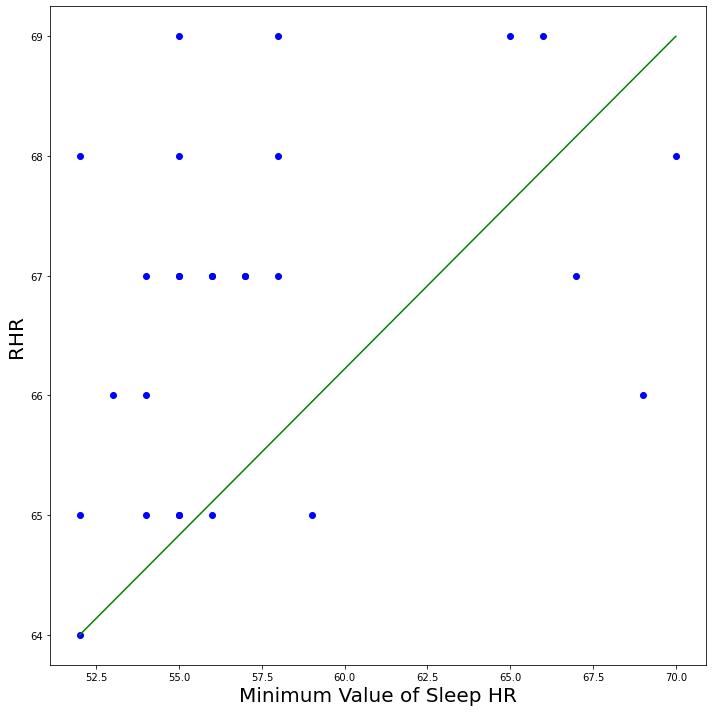

In [42]:
save_path = 'analysis_results'
if not os.path.exists(save_path):
    os.makedirs(save_path)
make_scatter_plot(df_analysis_data, os.path.join(save_path, 'min_sleepHR_RHR.png'))

## Linear regression

### Regression

In [44]:
# 学習用データ、テストデータに分割
X, y = df_analysis_data[['min_sleep_hr']].values, df_analysis_data[['RHR']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)  # 8:2にデータを分割

In [47]:
# 回帰直線の係数を導出
LR = LinearRegression()
LR.fit(X_train.reshape(-1, 1), y_train.reshape(-1, 1))
beta, beta0 = LR.coef_[0][0], LR.intercept_[0]
print("beta: {:.3f}".format(beta))
print("beta0: {:.3f}".format(beta0))

beta: 0.052
beta0: 63.744


In [80]:
print(y_test.reshape(-1).shape)
# r2_coff = r2_score(, y_train_pred.reshape(-1))

(6,)


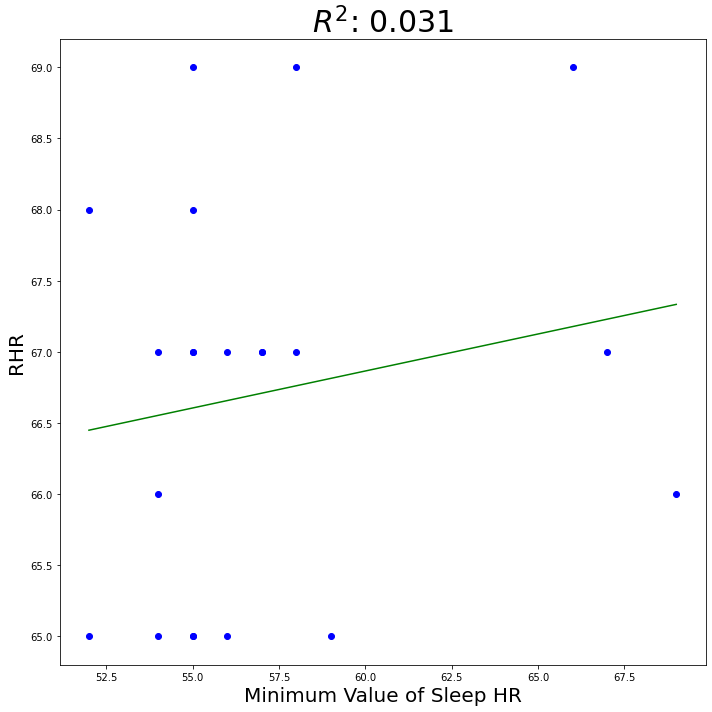

In [83]:
# 回帰直線を可視化
xrange = np.linspace(np.min(X_train), np.max(X_train), 100)
yrange = beta0 + beta * xrange
y_train_pred = beta0 + beta * X_train
r2_coff = r2_score(y_train.reshape(-1), y_train_pred.reshape(-1))
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.scatter(x=X_train, y=y_train, color='blue')
ax.plot(xrange, yrange, color='green')
ax.set_title("$R^2$: {:.3f}".format(r2_coff), fontsize=30)
ax.set_xlabel('Minimum Value of Sleep HR', fontsize=20)
ax.set_ylabel('RHR', fontsize=20)
plt.tight_layout()
plt.savefig(os.path.join(save_path, 'ex_linear_reg_minSleepHR_RHR.png'))

In [66]:
# priceの推定
y_pred = beta0 + beta * X_test
mae = mean_absolute_error(y_test, y_pred) # calc MAE
print("True RHR: {}".format(y_test.reshape(-1)))
print("Predicted RHR: {}".format(y_pred.reshape(-1).round(1)))
print("MAE: {:.2f}".format(mae))

True RHR: [69 66 68 68 64 67]
Predicted RHR: [67.1 66.5 67.4 66.8 66.4 66.7]
MAE: 1.17


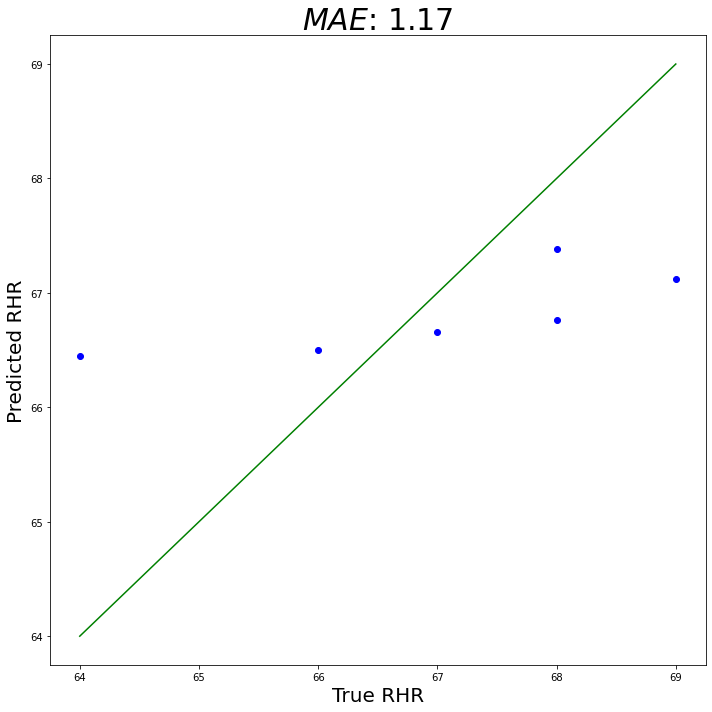

In [84]:
# 推定値と実際の値の比較
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.scatter(x=y_test, y=y_pred, color='blue')
xrange = np.linspace(np.min(y_pred.tolist() + y_test.tolist()), np.max(y_pred.tolist() + y_test.tolist()), 100)
ax.plot(xrange, xrange, color='green')
ax.set_title("$MAE$: {:.2f}".format(mae), fontsize=30)
ax.set_xlabel('True RHR', fontsize=20)
ax.set_ylabel('Predicted RHR', fontsize=20)
plt.tight_layout()
plt.savefig(os.path.join(save_path, 'ex_compare_true_pred_RHR.png'))

### Classification

In [115]:
# 正解の体調決定
threshold = np.median(df_analysis_data['RHR'])

true_condition = copy.deepcopy(y_test)
true_condition[true_condition<threshold] = 0
true_condition[true_condition>=threshold] = 1

pred_condition = copy.deepcopy(y_pred)
pred_condition[pred_condition<threshold] = 0
pred_condition[pred_condition>=threshold] = 1

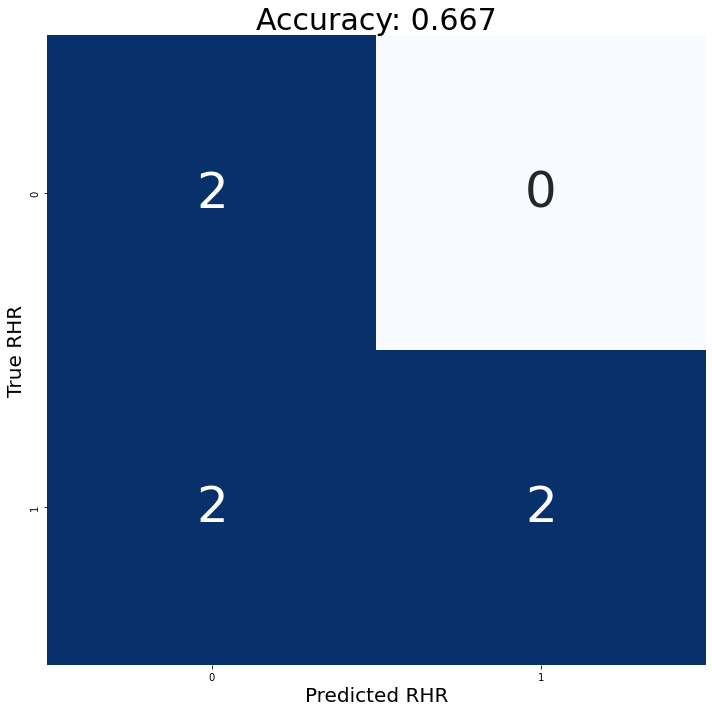

In [113]:
# Confusion matrix
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
conf_mat = confusion_matrix(true_condition, pred_condition)
acc = accuracy_score(y_true=true_condition, y_pred=pred_condition)
sns.heatmap(conf_mat, annot=True, cmap='Blues', cbar=False, annot_kws={"size":50})
ax.set_title('Accuracy: {:.3f}'.format(acc), fontsize=30)
ax.set_xlabel('Predicted RHR', fontsize=20)
ax.set_ylabel('True RHR', fontsize=20)
plt.tight_layout()
plt.savefig(os.path.join(save_path, 'Confusion_matrix.png'))

In [116]:
# Classification Report
print(classification_report(true_condition, pred_condition))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67         2
           1       1.00      0.50      0.67         4

    accuracy                           0.67         6
   macro avg       0.75      0.75      0.67         6
weighted avg       0.83      0.67      0.67         6

